# Figure 11

In [1]:
import numpy as np
import astropy.io.ascii as asci
import astropy.constants as const

from astropy.table import Table, vstack

import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

In [2]:
def get_vc_const(epsilon_e = 1/3, epsilon_B = 1/3):
    La = 1e+26

    eV = 1.60218e-12
    f = 0.5
    p = 3
    c1 = 6.27e+18
    c5 = 7.52e-24
    c6 = 7.97e-41
    Emin = 511e+3 * eV
    c = const.c.cgs.value
    
    epsilon = epsilon_e / epsilon_B
    
    nua = 5e+9 # 5 GHz
    numerator_R = 6 * c6**(p+5) * (La / (4 * np.pi))**(p+6)
    
    denominator_R = epsilon * f * (p-2) * np.pi**(p+5) * c5**(p+6) * Emin**(p-2)
    
    R_const = (numerator_R / denominator_R)**(1 / (2*p+13)) * 2 * c1 / nua

    # v_shock / c
    delta_t = 24 * 3600 # 1 day
    v_shock_const = R_const / delta_t
    return v_shock_const / c


def add_const_vsh(ax, vsh=0.01,  xmin =2, xmax = 500, ypos = 1.2e+27, par = 1):
    """
    vsh: shock velocity in units of c
    par:
        [1]: epsilon_e = 1/3, epsilon_B = 1/3
        [2]: epsilon_e = 0.1, epsilon_B = 0.01
    """
    if par == 1:
        epsilon_e = 1/3
        epsilon_B = 1/3
    elif par == 2:
        epsilon_e = 0.1
        epsilon_B = 0.01
    epsilon = epsilon_e / epsilon_B
    f = 0.5
    vc_const = get_vc_const(epsilon_e, epsilon_B)
    factor = vc_const * epsilon**(-1/19) * (f / 0.5)**(-1/19)
    
    xs = np.linspace(xmin, xmax) # x-axis
    ys = (xs * vsh / factor)**(19/9) * 1e+26
    color = "maroon"
    ax.plot(xs, ys, color=color, linewidth = 0.8, linestyle = ":")
    
    xpos = (ypos/1e+26)**(9/19) * factor / vsh
    if par==1:
        rotation = 50
    else:
        rotation = 50
    ax.text(xpos*1.1, ypos, r"$R / \Delta t=$"+str(vsh)+r"$c$", 
            rotation=rotation, color = color, fontsize = fs-1)
    
    
def get_ml_const(epsilon_e = 1/3, epsilon_B = 1/3):
    
    La = 1e+26

    eV = 1.60218e-12
    f = 0.5
    p = 3
    c1 = 6.27e+18
    c5 = 7.52e-24
    c6 = 7.97e-41
    Emin = 511e+3 * eV
    yr = 365.25 * 24* 3600
    mp = const.m_p.cgs.value
    Msun = const.M_sun.cgs.value
    Mdot_vw_unit = 1e-4 * Msun / yr / (1000 * 1e+5) # 1e-4 Msun / yr  / (1000 km/s)
    
    epsilon = epsilon_e / epsilon_B
    
    nua = 5e+9 # 5 GHz
    
    numerator_R = 6 * c6**(p+5) * (La / (4 * np.pi))**(p+6)
    denominator_R = epsilon * f * (p-2) * np.pi**(p+5) * c5**(p+6) * Emin**(p-2)
    R_const = (numerator_R / denominator_R)**(1 / (2*p+13)) * 2 * c1 / nua
    
    numerator_B = 36 * np.pi**3 * c5
    denominator_B = (epsilon * f * (p-2) * Emin**(p-2))**2 * c6**3 * La / (4 * np.pi)
    B_const = (numerator_B / denominator_B)**(2 / (2*p+13)) * nua / (2*c1)

    delta_t = 24 * 3600 # 1 day
    ne_const = (delta_t / R_const)**2 * 1 / mp  * B_const**2 / (6 * np.pi)
    
    # mass-loss
    epsilon_B = 1
    Mdot_vw_const = 4 *  np.pi * mp * R_const**2 * ne_const / Mdot_vw_unit
    return Mdot_vw_const
    
    
def add_const_massloss(ax, ml = 1,  xmin =2, xmax = 500, ypos = 2e+29, par = 1,
                       dotext = True):
    """
    ml: mass loss / wind velocity in standard unit
    """
    if par == 1:
        epsilon_e = 1/3
        epsilon_B = 1/3
    elif par == 2:
        epsilon_e = 0.1
        epsilon_B = 0.01
    epsilon = epsilon_e / epsilon_B
    f = 0.5
    ml_const = get_ml_const(epsilon_e, epsilon_B)
    factor = ml_const / epsilon_B * epsilon**(-8/19) * (f / 0.5)**(-1/19)
    xs = np.linspace(xmin, xmax)
    ys = (ml/(factor * xs**2))**(-19/4) * 1e+26
    color = "navy"
    ax.plot(xs, ys, color=color, linewidth = 0.8, linestyle = "--", alpha = 0.8, zorder = 1)
    xpos = np.sqrt(ml / ((ypos/1e+26)**(-4/19) * factor))
    if par==1:
        rotation = 80
    elif par==2:
        rotation = 80
    mylabel = r"$10^{%d}$"%(np.log10(ml))
    if ml == 0.01:
        mylabel = r"$\dot M_{-4} / v_{\rm w, 3}=10^{%d}$"%(np.log10(ml))
    if dotext:
        ax.text(xpos*1.06, ypos, mylabel, 
                rotation=rotation, color = color, fontsize = fs-1, alpha = 0.8, zorder = 1)


def Lp_to_UoverR(Lp, par = 1):
    epsilon = 1
    epsilon_B = 1
    f = 0.5
    La = 1e+26

    eV = 1.60218e-12
    f = 0.5
    p = 3
    c1 = 6.27e+18
    c5 = 7.52e-24
    c6 = 7.97e-41
    Emin = 511e+3 * eV
    
    nua = 5e+9 # 5 GHz
    numerator_R = 6 * c6**(p+5) * (La / (4 * np.pi))**(p+6)
    
    denominator_R = epsilon * f * (p-2) * np.pi**(p+5) * c5**(p+6) * Emin**(p-2)
    
    R_const = (numerator_R / denominator_R)**(1 / (2*p+13)) * 2 * c1 / nua
    numerator_B = 36 * np.pi**3 * c5
    
    denominator_B = (epsilon * f * (p-2) * Emin**(p-2))**2 * c6**3 * La / (4 * np.pi)
    
    B_const = (numerator_B / denominator_B)**(2 / (2*p+13)) * nua / (2*c1)
    
    U_const = 1 / epsilon_B * f * 4 * np.pi / 3 * R_const**3 * (B_const**2 / (8 * np.pi))
    
    # U / R
    UR_const = U_const / R_const
    #print ("  U / R const = %.2f e+29"%(UR_const / 1e+29))
    
    if par == 1:
        epsilon_e = 1/3
        epsilon_B = 1/3
    elif par == 2:
        epsilon_e = 0.1
        epsilon_B = 0.01

    epsilon = epsilon_e / epsilon_B
    
    UoverR = UR_const * (1/ epsilon_B) * epsilon**(-10/19) * (f/0.5)**(9/19) * (Lp / 1e+26)**(14/19)
    return UoverR 

In [3]:
def add_2020mrf(ax):
    color = "#ff0000"
    t1 = 261 # rest-frame days relative to explosion
    z = 0.1353
    Lp1 = 1.7e+29 / (1+z)**4 # erg/s/Hz
    nup1 = 7 # GHz
    x1 = t1 * (nup1/5)
    marker = '*'
    ms = 9
    ax.plot(x1, Lp1, marker = marker, markersize = ms, color = color, label = "AT2020mrf")
    ax.text(x1-10, Lp1*0.61, "%dd"%t1, color = color, fontsize = fs-1)
    
    
def add_css161010(ax):
    color = "#ff8c00"
    marker = "D"
    mylabel = "CSS161010"
    z = 0.034
    dt = asci.read("./ho_values/css161010_data")
    xx = 10**dt["x"].data
    yy = 10**dt["y"].data / (1+z)**4
    phase = [69, 357]
    
    ms = 6
    for j in range(len(xx)):
        if j==0:
            ax.plot(xx[j], yy[j], marker=marker, color = color, label = mylabel, markersize = ms)
        ax.plot(xx[j], yy[j], marker=marker, color = color, markersize = ms)
        if j==0:
            ax.text(xx[j]*0.55, yy[j]*0.92, "%dd"%phase[j], color = color, fontsize = fs-1)
        else:
            ax.text(xx[j]*0.5, yy[j]*0.92, "%dd"%phase[j], color = color, fontsize = fs-1)

    ax.plot(xx, yy, color = color)
    
    
def add_18lug(ax):
    color = "#17d459"
    marker = "D"
    mylabel = "AT2018lug"
    
    dt = asci.read("./ho_values/at2018lug_data")
    z = 0.271
    xx = 10**dt["x"].data
    yy = 10**dt["y"].data / (1+z)**4
    
    phase = [64, 343]
    ms = 6
    for j in range(len(xx)):
        if j==0:
            ax.plot(xx[j], yy[j], marker=marker, color = color, label = mylabel, markersize = ms)
        ax.plot(xx[j], yy[j], marker=marker, color = color, markersize = ms)
        if j==0:
            ax.text(xx[j]*0.55, yy[j]*0.92, "%dd"%phase[j], color = color, fontsize = fs-1)
        else:
            ax.text(xx[j]*1.1, yy[j]*0.92, "%dd"%phase[j], color = color, fontsize = fs-1)

    ax.plot(xx, yy, color = color)
    
    
def add_18cow(ax):
    color = "k"
    marker = "D"
    mylabel = "AT2018cow"
    dt = asci.read("./ho_values/at2018cow_data")
    dt1 = asci.read("./ho_values/at2018cow_data_n21")
    x = dt["x"].data
    y = dt["y"].data
    x1 = dt1["x"].data
    y1 = dt1["y"].data
    x = np.hstack([x, x1])
    y = np.hstack([y, y1])
    z = 0.014
    xx = 10**x
    yy = 10**y/(1+z)**4
    
    phase = [22, 91, 138]
    ms = 6
    for j in range(len(xx)):
        if j==0:
            ax.plot(xx[j], yy[j], marker=marker, color = color, label = mylabel, markersize = ms)
        ax.plot(xx[j], yy[j], marker=marker, color = color, markersize = ms)
        xpos = xx[j]*1.1
        ypos = yy[j]*0.92
        if j==2:
            xpos = xx[j]*0.52
        ax.text(xpos, ypos, "%dd"%phase[j], color = color, fontsize = fs-1)

    ax.plot(xx, yy, color = color)
    
    
def add_2020xnd(ax):
    color = "#6200ff"
    marker = "D"
    mylabel = "AT2020xnd"
    dt = asci.read("./ho_values/at2020xnd_data")
    z = 0.243
    
    xx = 10**dt["x"].data
    yy = 10**dt["y"].data / (1+z)**4
    phase = [58]
    ms = 6
    for j in range(len(xx)):
        if j==0:
            ax.plot(xx[j], yy[j], marker=marker, color = color, label = mylabel, markersize = ms)
        ax.plot(xx[j], yy[j], marker=marker, color = color, markersize = ms)
        ax.text(xx[j]*0.6, yy[j]*0.92, "%dd"%phase[j], color = color, fontsize = fs-1)
    

    ax.plot(xx, yy, color = color)

In [4]:
def add_normal_sn(ax, xmin = 2, xmax = 1e+3, ymin = 1e+22, ymax = 3e+30,
                  mylabel = "SNe II"):
    """
    Use lognormal distribution of Lpeak and nu_peak presented by Bietenholz+2021
    """
    multix = 0.6
    multiy = 0.9
    if mylabel == "SNe II":
        mu1 = 1.6
        sigma1 = 1.0
        mu2 = 25.3
        sigma2 = 1.3
        cmap = "Purples"
    elif mylabel == "SNe Ibc":
        mu1 = 1.1
        sigma1 = 0.5
        mu2 = 25.4
        sigma2 = 1.7
        cmap = "Blues"
    elif mylabel == "SNe IIn":
        mu1 = 3.1
        sigma1 = 0.7
        mu2 = 26.5
        sigma2 = 1.1
        cmap = "Greens"
        multix = 0.32
    elif mylabel == "SNe IIb":
        mu1 = 1.5
        sigma1 = 0.6
        mu2 = 26.8
        sigma2 = 0.5
        cmap = "Oranges"
    elif mylabel == "SNe BL":
        mu1 = 1.2
        sigma1 = 0.6
        mu2 = 26.7
        sigma2 = 1.7
        cmap = "Reds"
    else:
        print ("type is not known %s"%mylabel)
        return
    
    lgxmin = np.log10(xmin)
    lgxmax = np.log10(xmax)
    lgymin = np.log10(ymin)
    lgymax = np.log10(ymax)
    ngridx = 40
    ngridy = 50
    lgx = np.linspace(lgxmin, lgxmax, ngridx+1)
    lgy = np.linspace(lgymin, lgymax, ngridy+1)
    lgX, lgY = np.meshgrid(lgx, lgy, sparse=True)

    
    z = 1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-1 * (lgX - mu1)**2 / (2 * sigma1**2)) *\
        1 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-1 * (lgY - mu2)**2 / (2 * sigma2**2))
    
    maxz = max(z.ravel())
    levels = [maxz*0.3, maxz*0.5, maxz*0.7, maxz*0.9, maxz]
    ax.contourf(10**lgx, 10**lgy, z, zorder = 1, alpha = 0.3,
                cmap = cmap, levels=levels)
    
    cmapv = matplotlib.cm.get_cmap(cmap)
    midx = 10**mu1
    midy = 10**mu2
    color= cmapv(1.0)
    ax.text(midx*multix, midy*multiy, mylabel, color = color)

In [5]:
def add_llgrb_sn(ax, dolabel = True):
    dt1 = asci.read("./ho_values/2017iuk_data")
    dt1["y"] = 10**dt1["y"] / (1+0.0368)**4
    
    dt2 = asci.read("./ho_values/1998bw_data")
    dt2["y"] = 10**dt2["y"] / (1+ 0.0087)**4
    
    dt3 = asci.read("./ho_values/2006aj_data")
    dt3["y"] = 10**dt3["y"] / (1+ 0.03342)**4
    
    dt4 = asci.read("./ho_values/2010bh_data")
    dt4["y"] = 10**dt4["y"] / (1+ 0.059)**4
    
    dt = vstack([dt1, dt2, dt3, dt4])
    
    xx = 10**dt["x"].data
    yy = dt["y"].data
    
    color = "grey"
    ms = 4.5
    marker = "s"
    mylabel = "GRB-SNe"
    ax.plot(xx, yy, markeredgecolor = color, markerfacecolor = "white",
            marker = marker, markersize = ms, markeredgewidth = 1.5,
            label = mylabel, linestyle = "none")
    if dolabel:
        ax.text(xx[0]*1.1, yy[0]*0.9, "17iuk", color = color, fontsize = fs-1)
        ax.text(xx[1]*1.1, yy[1]*0.9, "98bw", color = color, fontsize = fs-1)
        ax.text(xx[2]*1.1, yy[2]*0.9, "06aj", color = color, fontsize = fs-1)
        ax.text(xx[3]*1.1, yy[3]*0.9, "10dh", color = color, fontsize = fs-1)
        

In [6]:
def custom_ax_shock(ax, par=1,
                    xmin = 2, xmax = 1e+3, ymin = 1e+22, ymax = 3e+30):
    ax.semilogx()
    ax.semilogy()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    if par == 1:
        add_const_vsh(ax, vsh=0.01, xmin=xmin, xmax = xmax, ypos = 1e+27, par=par)
        add_const_vsh(ax, vsh=0.1, xmin=xmin, xmax = xmax, ypos = 1e+27, par=par)
        add_const_vsh(ax, vsh=1, xmin=xmin, xmax = xmax, ypos = 1e+27, par=par)
        
        add_const_massloss(ax, ml = 0.01, xmin=xmin, xmax = xmax, ypos = 0.3e+30, par=par)
        add_const_massloss(ax, ml = 0.1, xmin=xmin, xmax = xmax, ypos = 2.4e+30, par=par)
        add_const_massloss(ax, ml = 1, xmin=xmin, xmax = xmax, ypos = 2.4e+30, par=par)
        add_const_massloss(ax, ml = 10, xmin=xmin, xmax = xmax, ypos = 2.4e+30, par=par, dotext = False)
        
    else:
        add_const_vsh(ax, vsh=0.01, xmin=xmin, xmax = xmax, ypos = 2e+27, par=par)
        add_const_vsh(ax, vsh=0.1, xmin=xmin, xmax = xmax, ypos = 2e+27, par=par)
        add_const_vsh(ax, vsh=1, xmin=xmin, xmax = xmax, ypos = 2e+27, par=par)
        
        add_const_massloss(ax, ml = 0.01, xmin=xmin, xmax = xmax, par=par, ypos = 0.35e+30)
        add_const_massloss(ax, ml = 0.1, xmin=xmin, xmax = xmax, par=par, ypos = 2.6e+30)
        add_const_massloss(ax, ml = 1, xmin=xmin, xmax = xmax, par=par, ypos = 2.6e+30)
        add_const_massloss(ax, ml = 10, xmin=xmin, xmax = xmax, par=par, ypos = 2.6e+30)

    
    ax.tick_params(which = 'major', length = 4, top=True, direction = "in", right = False)
    ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", right = False)
    
    
    ax.set_xlabel("("+r"$\Delta t/{\rm 1\,}$"+"day)"+r"$\times$"+"("+r"$\nu_{\rm peak}/{\rm 5\,}$"+"GHz)")
    ax.set_ylabel(r"$L_{\theta \nu\, {\rm peak}}$"+" ("+r"$\rm erg\,s^{-1}\,Hz^{-1}$"+")")
    if par==1:
        ax.text(xmin*1.1, ymax*0.5, r"$ϵ_e = ϵ_B = 1/3$", fontsize = fs)
    elif par==2:
        ax.text(xmin*1.1, ymax*0.5, r"$ϵ_e =0.1$", fontsize = fs)
        ax.text(xmin*1.1, ymax*0.25, r"$ϵ_B = 0.01$", fontsize = fs)
        
    ########## right y axis ##########
    axi2 = ax.twinx()
    axi2.tick_params(which = 'major', length = 4, direction = "in")
    axi2.tick_params(which = 'minor', length = 2, direction = "in")
    axi2.semilogy()
    ymax2 = Lp_to_UoverR(ymax, par = par)
    ymin2 = Lp_to_UoverR(ymin, par = par)
    #ymajor_real = np.array(1e+32, 1e+31)
    axi2.set_ylim(ymin2, ymax2)
    axi2.set_ylabel(r"$U/R$"+" (erg"+r"$\rm \, cm^{-1}$"+")")    

In [7]:
def make_shock_diagram(par = 1):
    xmin = 2
    xmax = 1e+3
    if par == 1:
        plt.figure(figsize = (4.8, 5.5))
        ymin = 1e+25
        ymax = 7e+30
        dolabel = True
    elif par == 2:
        plt.figure(figsize = (4.8, 3.5))
        ymin = 1e+27
        ymax = 7e+30
        dolabel = False
    ax = plt.subplot(111)
    
    
    custom_ax_shock(ax , par=par, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax)
    
    add_2020mrf(ax)
    add_css161010(ax)
    add_18lug(ax)
    add_18cow(ax)
    add_2020xnd(ax)
    
    add_llgrb_sn(ax, dolabel=dolabel)
    
    if par == 1:
        add_normal_sn(ax, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, mylabel = "SNe II")
        add_normal_sn(ax, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, mylabel = "SNe Ibc")
        add_normal_sn(ax, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, mylabel = "SNe IIn")
        add_normal_sn(ax, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, mylabel = "SNe IIb")
        #add_normal_sn(ax, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, mylabel = "SNe BL")
    
    if par == 1:
        ax.legend(bbox_to_anchor = (-0.12, 1.14), loc = "upper left", ncol = 3)
        plt.tight_layout(rect =(-0.03, -0.04, 1.04, 1.01))
        
    elif par == 2:
        plt.tight_layout(rect =(-0.03, -0.05, 1.04, 1.03))

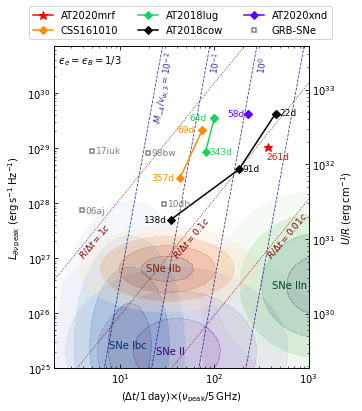

In [8]:
make_shock_diagram(par = 1)

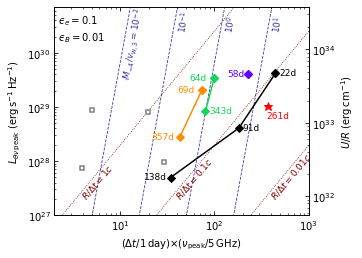

In [9]:
make_shock_diagram(par = 2)